In [51]:
import pandas as pd
import plotnine as pn
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from string import punctuation
from scipy import stats

## Анализ жилой недвижимости Тюмени

### Примечание

Данная работа является примером исследовательской задачи. Это всего лишь черновик. Автор не претендует на оригинальность, установление ИСТИНЫ или создание модели машинного обучения с идеальными предсказаниями. Основная (и единственная) цель - показать как устроена аналитика "под капотом", и как ею заниматься, использую open source технологии, доступные каждому.

Поехали!

### Введение

Допустим, вы задумались над тем, как формируется стоимость квартиры. Американские риэлторы давно уже нашли ответ на этот вопрос - из 3 составляющих: местоположения, местоположения и местоположения. Это, конечно, замечательная максима, но зачастую задачи о причинно-следственных связях намного сложней и не умещаются в запоминающуюся цитату.

Попробуем разобраться самостоятельно.

Первая проблема - у нас в отличии от крупных агентств недвижимости нет базы данных. Но у нас есть доступ в интернет, Python и библиотека __[scrapy](https://scrapy.org/)__. Напишем небольшую программу, которая будет сама ходить по страницам сайта агентства недвижимости, на которых размещены объявления о продаже квартиры. В качестве источника возьмем сайт __[АН "Сова"](https://www.sova72.ru/tyumen)__, т.к. у него простая и понятная структура. Будем вежливыми - ограничимся 2 запросами в секунду. Это займет больше времени на сбор информации, но закидывать сервер огромным количеством обращений, во-первых, не этично, а, во-вторых, может привести к блокировке IP-адреса.

Итак, одну вечность спустя мы посетили **2331 HTML-страницу** и сохранили их у себя на диске. Теперь из каждой страницы извелечем данные, которые пригодятся нам для анализа:

 - адрес;
 - высота потолка;
 - год постройки;
 - идентификатор;
 - материал;
 - мебель;
 - общая площадь;
 - описание;
 - площадь кухни;
 - ремонт;
 - цена;
 - этаж;


IT-специалисты называют такую операцию "парсинг". Наконец, мы получили табличку в виде csv-файла, с которой уже можем работать.

### Импорт данных

Загрузим данные и посмотрим на первые 5 записей:

In [52]:
df = pd.read_table('./sova_all.csv', delimiter='|')

In [53]:
df.head()

,Адрес,Высота потолка,Год постройки,Идентификатор,Материал,Мебель,Общая площадь,Описание,Площадь кухни,Ремонт,Цена,Этаж
0,"3 комнатная квартира в районе МЖК, ул. Широтн...",NaN,1992,484678,Панель,Частично,65 м²,Трехкомнатная квартира в районе улиц Монтажник...,10 м²,Хороший ремонт,6 000 000 ₽,2 из 9
1,"Студия в районе Лесобаза (Тура), ул. Западноси...",NaN,2012,462640,Панель,Полностью,24.8 м²,Продается квартира-студия. В квартире выполнен...,4 м²,Обычное состояние,2 580 000 ₽,9 из 9
2,"Многокомнатн. квартира в районе с. Сосновое, ...",NaN,1991,282813,Кирпич,NaN,133.8 м²,Большая квартира для большой и дружной семьи! ...,12 м²,Обычное состояние,3 000 000 ₽,3 из 5
3,4 комнатная квартира в районе Тюменская слобо...,NaN,2020,463424,Монолитный,Без мебели,137 м²,Продаётся просторная квартира с шикарным видом...,25.4 м²,Улучшенная черновая,9 200 000 ₽,20 из 23
4,"4 комнатная квартира в 3 микрорайоне, ул. Шир...",NaN,1977,425792,Панель,NaN,75.9 м²,"Классная квартира в самом центре уютного , ком...",10 м²,Хороший ремонт,4 750 000 ₽,5 из 5


Сразу видим, что столбцы **Общая площадь**, **Площадь кухни** и **Цена** импортированы как текстовые переменные. Т.е. мы не можем выполнять с ними арифметические операции. Их надо будет преобразовать в нужный нам числовой тип.

Также видим, что не у всех записей есть полные данные. Значение `NaN` означает отсутствие информации. Проверим какой процент пропусков в каждом столбце:

In [54]:
df.isna().mean().sort_values(ascending=False)[lambda x: x > 0] * 100

Высота потолка    69.498069
Мебель            27.627628
Материал           1.673102
Описание           0.643501
Ремонт             0.128700
dtype: float64

Видим, что 69,5% записей в столбце **Высота потолка** не заполнены, у столбца **Мебель** - 27,6% пропусков.

### Предобработка данных

Приведем таблицу к формату, при котором можно проводить анализ. Для этого:

 - из столбцов **Общая площадь** и **Площадь кухни** удалим символы *м²* и преобразуем их в числовой формат;
 - из столбца **Цена** удалим символ *₽*, пробелы между разрядами и также преобразуем в числовой формат;
 - столбец **Этаж** преобразуем в категориальный признак с тремя значениями - первый, последний, другой;
 - из столбца **Адрес** извлечем количество комнат и добавим их отдельным столбцом;
 - уберем столбцы, информацию из которых мы не можем использовать с толком для нашего задачи - **Адрес**, **Высота потолка**, **Идентификатор**, **Мебель**, **Описание**.
 
*Примечание:* Конечно, информация об адресе очень важна, т.к. квартиры в историческом центре наверняка дороже квартир на окраинах. Но чтобы ее использовать, нам надо каждый адрес привязать к району. Делать это вручную - занятие долгое и утомительное, а на поиски API-сервиса, который бы возвращал нам название района для адреса, у нас времени нет. Нам ведь не платят за эту работу (но это только пока... 😎).

In [55]:
rus_to_eng = {
    'Адрес': 'address',
    'Высота потолка': 'ceiling_height',
    'Год постройки': 'year_built',
    'Идентификатор': 'id',
    'Материал': 'material',
    'Мебель': 'furniture',
    'Общая площадь': 'area_total',
    'Описание': 'description',
    'Площадь кухни': 'area_kitchen',
    'Ремонт': 'renovated',
    'Цена': 'price',
    'Этаж': 'floor',
    'Цена кв.м.': 'price_sqm',
    'Тип этажа': 'floor_type',
    'Комнат': 'rooms',
    'Возраст': 'age',
}

eng_to_rus = {
    'address': 'Адрес',
    'ceiling_height': 'Высота потолка',
    'year_built': 'Год постройки',
    'id': 'Идентификатор',
    'material': 'Материал',
    'furniture': 'Мебель',
    'area_total': 'Общая площадь',
    'description': 'Описание',
    'area_kitchen': 'Площадь кухни',
    'renovated': 'Ремонт',
    'price': 'Цена',
    'floor': 'Этаж',
    'price_sqm': 'Цена кв.м.',
    'floor_type': 'Тип этажа',
    'rooms': 'Комнат',
    'age': 'Возраст',
}

In [56]:
df.rename(columns=rus_to_eng, inplace=True)

In [57]:
df.price = df.price.str.replace(pat='\D', repl='', regex=True).astype('int')

In [58]:
df.area_total = df.area_total.str.replace(pat='м²', repl='', regex=False).astype('float')

In [59]:
df.area_kitchen = df.area_kitchen.str.replace(pat='м²', repl='', regex=False).astype('float')

In [60]:
df.ceiling_height = df.ceiling_height.str.replace(pat='м', repl='', regex=False).astype('float')

In [61]:
df['price_sqm'] = df.price / df.area_total

In [62]:
def categorize_floor(text):
    parts = text.split()
    if parts[0] == '1':
        return 'Первый'
    elif parts[0] == parts[-1]:
        return 'Последний'
    else:
        return 'Другой'

In [63]:
df['floor_type'] = df.floor.apply(lambda x: categorize_floor(x))

In [64]:
df['rooms'] = df.address.apply(lambda x: x.split()[0].strip(punctuation))

df['rooms'] = pd.Categorical(values=df.rooms, 
                             categories=['Студия', '1', '2', '3', '4', 'Многокомнатн',], 
                             ordered=True)

Итак, после всех преобразований таблица выглядит так:

In [65]:
cols = ['id', 'address', 'year_built', 'material', 'area_total', 'area_kitchen', 'renovated',
       'price', 'price_sqm', 'floor_type', 'rooms', ]

df[cols].rename(columns=eng_to_rus)

,Идентификатор,Адрес,Год постройки,Материал,Общая площадь,Площадь кухни,Ремонт,Цена,Цена кв.м.,Тип этажа,Комнат
0,484678,"3 комнатная квартира в районе МЖК, ул. Широтн...",1992,Панель,65.0,10.0,Хороший ремонт,6000000,92307.692308,Другой,3
1,462640,"Студия в районе Лесобаза (Тура), ул. Западноси...",2012,Панель,24.8,4.0,Обычное состояние,2580000,104032.258065,Последний,Студия
2,282813,"Многокомнатн. квартира в районе с. Сосновое, ...",1991,Кирпич,133.8,12.0,Обычное состояние,3000000,22421.524664,Другой,Многокомнатн
3,463424,4 комнатная квартира в районе Тюменская слобо...,2020,Монолитный,137.0,25.4,Улучшенная черновая,9200000,67153.284672,Другой,4
4,425792,"4 комнатная квартира в 3 микрорайоне, ул. Шир...",1977,Панель,75.9,10.0,Хороший ремонт,4750000,62582.345191,Последний,4
...,...,...,...,...,...,...,...,...,...,...,...
2326,474046,"4 комнатная квартира в районе КСМ, ул. Револю...",1994,Кирпич,121.0,25.0,Обычное состояние,2200000,18181.818182,Другой,4
2327,454116,"1 комнатная квартира в Европейском мкрн., ул....",2021,Монолитно-кирпичный,46.3,14.6,Улучшенная черновая,5100000,110151.187905,Другой,1
2328,456903,1 комнатная квартира в районе Московского тр....,2019,Кирпич,38.2,16.0,Улучшенная черновая,3200000,83769.633508,Другой,1
2329,487355,"1 комнатная квартира в Тюменском-3 мкрн., ул....",2013,Монолитно-каркасный,39.2,12.0,Обычное состояние,4095000,104464.285714,Другой,1


Осталось еще одно дело в предобработке. Посмотрим на количество записей в каждой категории в столбцах **Материал** и **Ремонт**.

Посмотрим на категории в столбце **Тип ремонта**:

In [66]:
df.renovated.value_counts()

Хороший ремонт         1161
Обычное состояние       513
Дизайн-проект           272
Улучшенная черновая     232
Частичный ремонт         48
Требует ремонта          48
Черновая отделка         32
От строителей            22
Name: renovated, dtype: int64

Любопытно, что половина квартир имеет **Хороший ремонт**. Рискнем предположить, что **Черновая отделка** и **От строителей** - это по сути одна категория. Соответственно, объединим эти записи под **Черновой отделкой**.

In [67]:
df.renovated = df.renovated.apply(lambda x: 'Черновая отделка' if x == 'От строителей' else x)

Теперь посмотрим на частотность категорий в столбце **Материал**:

In [68]:
df.material.value_counts()

Кирпич                 1076
Панель                  558
Монолитно-каркасный     337
Монолитно-кирпичный     238
Монолитный               55
Блоки                    22
Дерево                    5
Экспериментальный         1
Name: material, dtype: int64

Видим, что есть записи по домам из блоков, дерева и даже экспериментального материала. Данных по таким домам относительно мало, чтобы делать какие-то обобщения. У статистиков есть практическое правило - наблюдений должно быть хотя бы 30, чтобы делать какие-то заключения. Конечно, это не теорема, а лишь правило из практики, но и мы тут не претендуем на докторскую степень. Уберем эти записи из нашей таблицы.


In [69]:
material_to_exclude = ['Экспериментальный', 'Дерево', 'Блоки', ]
df = df[cols].query('material not in @material_to_exclude').dropna().copy()

### Анализ

Наконец-то переходим к сути вопроса. Какая досада, что 70-80% времени нужно тратить на добывание и обработку данных... 

Начнем со стоимости. Какова средняя цена 1 квадратного метра?

In [70]:
int(df['price_sqm'].mean())

87676

87 676 рублей. Но это то что называется средняя температура - здесь и дома 1980 года и новостройки, то есть все в кучу. Посмотрим лучше на распределение этой величины:

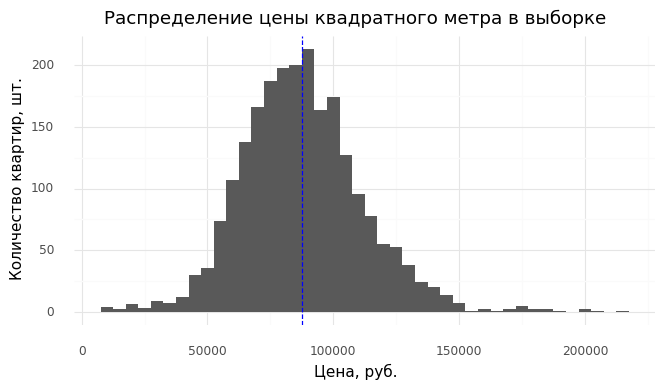

<ggplot: (8750463289772)>

In [71]:
price_sqm_hist = (
    pn.ggplot(mapping=pn.aes(x='price_sqm'), data=df) +
    pn.geom_histogram(binwidth=5000) +
    pn.geom_vline(xintercept=df['price_sqm'].mean(), linetype='dashed', color='blue') + 
    pn.theme_minimal() +
    pn.theme(figure_size=(7.5, 3.75)) +
    pn.xlab('Цена, руб.') +
    pn.ylab('Количество квартир, шт.') +
    pn.ggtitle('Распределение цены квадратного метра в выборке')
)
price_sqm_hist

Видим, что в целом распределение довольно симметричное относительно среднего (голубой пунктирной линии), но имеются аномалии - квартиры с ценой сильно выше/ниже среднего. Статистики называют это тяжелыми хвостами. Для моделей машинного обучения, цель которых предсказание цены, такие аномалии представляют серьезные трудности.

Такие визуализации также могут служить для допольнительных проверок данных на корректность - действительно ли есть квартиры с ценой больше 225 тысяч и меньше 25 тысяч. Бывает, что данные заносят с ошибками.

Проверим сначала левый хвост. Посмотрим на 1% самых квартир с самой низкой стоимостью квадратного метра:

In [72]:
lims = df['price_sqm'].quantile(q=[0.01, 0.99]).values
lims

array([ 32004.62552011, 150000.        ])

In [73]:
cols = ['id', 'address', 'area_total', 'price', 'price_sqm', 'year_built',]
mask = 'price_sqm <= @lims[0]'
tbl = (df.query(mask)
         .sort_values('price_sqm')[cols]   
      )
ids = tbl.id.values
tbl.rename(columns=eng_to_rus).style.set_properties(subset=['Адрес'], **{'width': '500px'})

,Идентификатор,Адрес,Общая площадь,Цена,Цена кв.м.,Год постройки
2214,427223,"4 комнатная квартира , ул. Свердлова, 2А, п. Юшала",77.600000,780000,10051.546392,1985
27,446599,"4 комнатная квартира , ул. 8 Марта, 32, п. Луговской",61.400000,650000,10586.319218,1989
1065,337212,"4 комнатная квартира , ул. Ленина, 24, с. Басмановское",70.000000,800000,11428.571429,1990
1467,242967,"2 комнатная квартира , ул. 30 лет Победы, 16, п. Октябрьский",49.100000,600000,12219.959267,1981
1457,398114,"4 комнатная квартира , ул. Стройгородок, 4, с. Вагай",99.000000,1400000,14141.414141,1970
1822,156268,"4 комнатная квартира , ул. 8 Марта, 30А, п. Луговской",68.700000,1100000,16011.644833,1985
2326,474046,"4 комнатная квартира в районе КСМ, ул. Революции, 181, г. Ялуторовск",121.000000,2200000,18181.818182,1994
892,318782,"2 комнатная квартира , ул. Стройгородок, 5, с. Вагай",44.000000,850000,19318.181818,1990
2310,296261,"3 комнатная квартира , ул. Железнодорожников, 7, п. Картымский",49.400000,1000000,20242.914980,1970
637,278057,"1 комнатная квартира , ул. Калинина, 6, с. Шорохово",29.000000,600000,20689.655172,1995


Все квартиры в поселках, а не в Тюмени. Уберем их, чтобы не искажали общую картину.

Теперь посмотрим на 1% квартир с самым дорогим квадратным метром:

In [74]:
mask = 'price_sqm >= @lims[1]'
tbl = (df.query(mask)
         .sort_values('price_sqm')[cols]
         .rename(columns=eng_to_rus)
      )

tbl.style.set_properties(subset=['Адрес'], **{'width': '500px'})

,Идентификатор,Адрес,Общая площадь,Цена,Цена кв.м.,Год постройки
2145,474451,"Студия в районе Плеханово, ул. Новоселов, 107/2,",15.000000,2250000,150000.000000,2019
1830,463156,"Студия в районе Плеханово, ул. Новоселов, 117,",16.000000,2400000,150000.000000,2018
1683,350589,"Студия в Тюменском-3 мкрн., ул. Дмитрия Менделеева, 2,",30.000000,4500000,150000.000000,2018
29,437812,"Студия в районе Мыс, ул. Парада Победы, 7, ЖК «Зеленый мыс», г. Тюмень",21.000000,3160000,150476.190476,2020
1668,486739,"Студия в районе Плеханово, ул. Новоселов, 115,",15.900000,2400000,150943.396226,2018
1252,474116,"1 комнатная квартира в районе Дома печати, ул. 50 лет Октября, 4,",56.000000,8600000,153571.428571,2019
850,486584,"Студия в районе Большая зарека, ул. Луговая 2я, 22/1,",30.000000,4750000,158333.333333,2020
444,441474,"Студия в районе Дома печати, ул. Сакко, 24,",41.200000,6600000,160194.174757,2019
2081,460404,"Студия в районе Плеханово, ул. Новоселов, 117,",15.700000,2555000,162738.853503,2018
1286,483551,"2 комнатная квартира в Европейском мкрн., ул. Газовиков, 44,",53.600000,9100000,169776.119403,2021


Последние записи списка не удивляют - высокая стоимость квадратного метра в современных домах в центре города. Исключение составляет только запись 754 - дом 1964 года постройки на Ленина, 65 с ценой за кв.м. в 198 150 рублей.

Верхняя часть списка довольно любопытна - маленькие студии на окраине города по 150 000 руб./кв.м. То ли действительно пользуются спросом, то ли выставили на продажу по неадекватной цене...

In [75]:
df = df.query('id not in @ids').copy()

Посмотрим, как цена кв.м. зависит от года постройки дома. Построим диаграмму рассеивания:

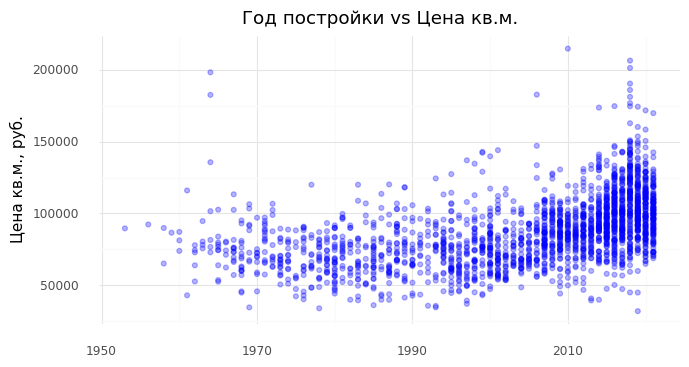

<ggplot: (8750463285101)>

In [76]:
price_year_plot = (
    pn.ggplot(mapping=pn.aes(x='year_built', y='price_sqm'), data=df) +
    pn.geom_point(alpha=0.3, color='blue') +
    pn.theme_minimal() +
    pn.theme(figure_size=(7.5, 3.75)) +
    pn.xlab('') +
    pn.ylab('Цена кв.м., руб.') +
    pn.ggtitle('Год постройки vs Цена кв.м.')
)
price_year_plot

Чем дом новее, тем выше стоимость квадратного метра (тоже мне открытие!). Сразу видим наших знакомых - точки со значениями больше 150 000 руб. для домов примерно 1965-1970 годов постройки. Тот самый дом на ул. Ленина, 65.

Ну ладно, всякое бывает. Нас интересуют общие тендеции, поэтому мы избавимся от лишнего "шума" в данных:

 - сгруппируем данные по годам и оставим только те группы, в которых есть хотя бы 20 записей;
 - для каждой группы посчитаем медиану (т.к. она меньше подвержена искажениям чем арифметическое среднее);
 - вместо года постройки используем возраст дома - текущий год минус год постройки;
 - построим новую диаграмму рассеивания;

In [77]:
tbl = (df.groupby('year_built')['price_sqm']
         .agg(['count', 'median'])
         .query('count >= 20')
         .reset_index())

In [78]:
tbl['age'] = 2021 - tbl.year_built

In [79]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x=tbl['age'], y=tbl['median'])

In [80]:
lims = int(abs(slope + 2*std_err)), int(abs(slope + -2*std_err))

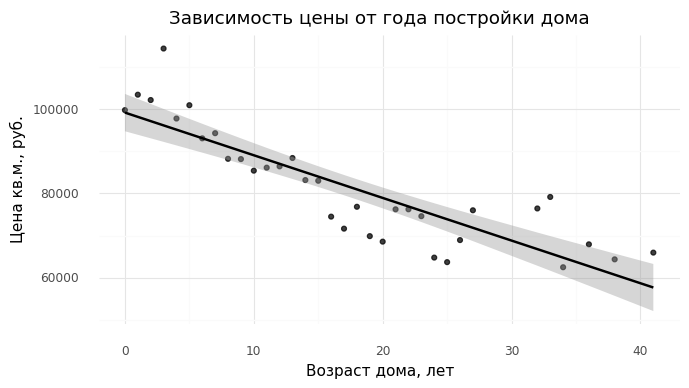

<ggplot: (8750463334690)>

In [81]:
price_age_plot = (
    pn.ggplot(mapping=pn.aes(x='age', y='median'), data=tbl) +
    pn.geom_point(alpha=0.75) +
    pn.geom_smooth(method='lm') +
    pn.theme_minimal() +
    pn.theme(figure_size=(7.5, 3.75)) +
    pn.xlab('Возраст дома, лет') +
    pn.ylab('Цена кв.м., руб.') +
    pn.ggtitle('Зависимость цены от года постройки дома')
)
price_age_plot

In [82]:
lims

(802, 1222)

Здесь мы уже имеем дело с простенькой моделью линейной регрессии от одной переменной (черная прямая линия). На человеческом языке это можно выразить так: 

 1. средняя стомость квадртаного метра в новом доме составляет 100 000 рублей;
 2. с каждым годом прибавляемым к возрасту дома стоимость квадратного метра снижается на 800-1200 рублей.
 


Далее взглянем на то, как распределяется цена в зависимости от технологии строительства. Построим график ящик с усами:

In [83]:
material_order = df.groupby('material')['price_sqm'].median().sort_values(ascending=False).index

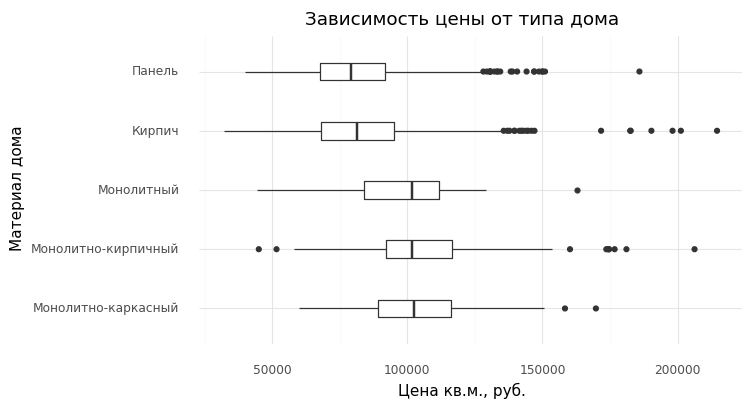

<ggplot: (8750454933203)>

In [84]:
material_boxplot = (
    pn.ggplot(mapping=pn.aes(x='material', y='price_sqm'), data=df) +
    pn.geom_boxplot(width=0.3) +
    pn.scale_x_discrete(limits=material_order) +
    pn.theme_minimal() +
    pn.theme(figure_size=(7, 4)) +
    pn.coord_flip() +
    pn.ylab('Цена кв.м., руб.') +
    pn.xlab('Материал дома') +
    pn.ggtitle('Зависимость цены от типа дома')
)
material_boxplot

Черта внутри ящика - средняя цена (медиана) для домов такой-то категории. Ширина ящика показывает, что 50% всех значений находятся в таком интервале. Точки показывают выбросы - объекты с ценой сильно выше/ниже среднего.

Из графика видим, что дома с монолитной технологией строительства имеют примерно одинаковую средняя стоимость квадратного метра. У кирпичных домов она ниже, а у панельных самая низкая. 

Может панельные дома ценятся ниже. А может монолитные дома просто новее (технология стала активно применяться лишь недавно), поэтому и стоимость квадратного метра там выше. Одним словом, не спешим с выводами.

In [85]:
renovated_list = df.groupby('renovated')['price_sqm'].median().sort_values(ascending=False).index

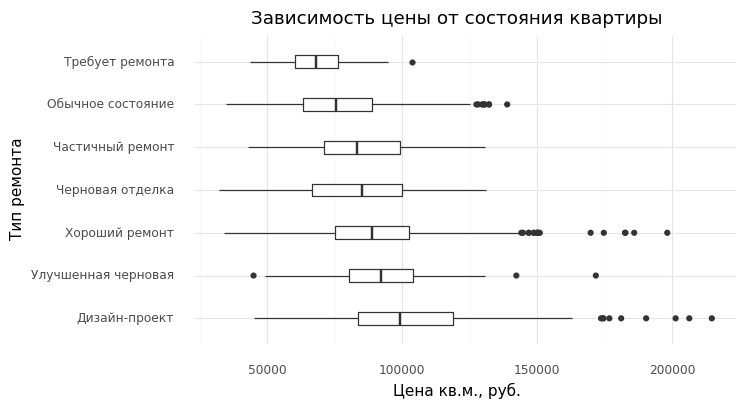

<ggplot: (8750454869495)>

In [86]:
renovation_boxplot = (
    pn.ggplot(mapping=pn.aes(x='renovated', y='price_sqm'), data=df) +
    pn.geom_boxplot(width=0.3) +
    pn.scale_x_discrete(limits=renovated_list) +
    pn.theme_minimal() +
    pn.theme(figure_size=(7, 4)) +
    pn.coord_flip() +
    pn.ylab('Цена кв.м., руб.') +
    pn.xlab('Тип ремонта') +
    pn.ggtitle('Зависимость цены от состояния квартиры')
)
renovation_boxplot

Любопытно, что квартира с **Улучшенной черновой** отделкой в среднем стоит больше чем с **Хорошим ремонтом**. Может потому, что степень хорошести понятие субъективное, а может причина опять в возрасте дома (улучшенная черновая чаще встречается в новостройках).

Также примечательно, что средняя стоимость квадратного метра при **Частичном ремонте** и **Черновой отделке** примерно одинаковая. Так что не пытайтесь заработать на ремонте - покупатели вряд ли оценят.

В категории **Дизайн-проект** видим много точек в районе 175 000 - 200 000. Видимо, это все экслюзивные ремонты с дорогими материалами.

Еще отметим, что ящики **Дизайн-проект** и **Хороший ремонт** намного более вытянутые (как тело, так и усы), что указывает на намного больший разброс цен в этих категориях. Косвенное свидтельство того, что у всех свои представления о прекрасном и дороговизне материалов.

Напоследок взглянем на распределение цен в зависимости от этажа, на котором расположена квартира:

In [87]:
floor_list = df.groupby('floor_type')['price_sqm'].median().sort_values(ascending=False).index

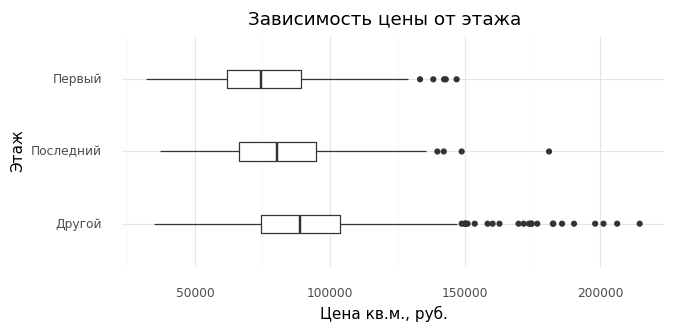

<ggplot: (8750454878094)>

In [88]:
floor_boxplot = (
    pn.ggplot(mapping=pn.aes(x='floor_type', y='price_sqm'), data=df) +
    pn.geom_boxplot(width=0.25) +
    pn.scale_x_discrete(limits=floor_list) +
    pn.theme_minimal() +
    pn.theme(figure_size=(7, 3)) +
    pn.coord_flip() +
    pn.ylab('Цена кв.м., руб.') +
    pn.xlab('Этаж') +
    pn.ggtitle('Зависимость цены от этажа')
)
floor_boxplot

Похоже люди в основном действительно предпочитают не первый и не последнй этажи, т.к. средняя цена кв.м. наибольшаяя для любого другого этажа кроме этих.

До настоящего момента мы рассматривали отношения какой-то одной переменной (года постройки, тип ремонта, ...) и цены. Из жизненного опыта известно, что на цену влияют все эти факторы в совокупности. Попробуем разобраться, какие из них наиболее важные.

### Моделирование

Построим модель множественной регресии. Звучит жутковато, но на деле все не так страшно. Мы пытаемся понять как разные факторы влияют на конечную стоимость квартиры **все вместе**, а не по отдельности. 

Ограничимся пока несколькими переменными. Будем увязывать стоимость квартиры с:

 1. общей площадью;
 2. восрастом дома;
 3. этажом;


Нашу таблицу разобьем на две части в соотношении 80/20% - тренировочную выборку и тестовую. На первой будем строить модель, показывая ей, что квартира с такими-то характеристиками стоит столько-то. Тестовая выборка используется для проверки качества модели. В модель отправляются только признаки квартиры (без цены), а модель делает предсказания оценки на основе того, чему она научилась на тренировочной выборке. Затем полученные предсказания можно сравнить с фактическими значениями и посмотреть насколько точно работает модель. 

In [89]:
df['age'] = 2021 - df.year_built

In [90]:
x = df.drop(columns=['id', 'address', 'price', 'year_built', 'price_sqm'])
y = df['price']

In [91]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [92]:
fml = 'price ~ area_total + age + floor_type'

In [93]:
lm = smf.ols(formula=fml,
                 data=pd.concat([x_train, y_train], axis=1))
lm = lm.fit()

Получили такой отчет о построенной модели:

In [94]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     1210.
Date:                Thu, 16 Sep 2021   Prob (F-statistic):               0.00
Time:                        12:45:37   Log-Likelihood:                -28421.
No. Observations:                1791   AIC:                         5.685e+04
Df Residuals:                    1786   BIC:                         5.688e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                9.879e+05   9.78e+04     10.096      0.000    7.96e+05    1.18e+06
floor_type[T.Первый]    -5.156e+05   1.52e+05     -3.390      0.001   -8.14e+05   -2.17e+05
floor_type[T.Последний] -2.043e+05   1.37e+05     -1.492      0.136   -4.73e+05    6.42e+04
area_total               7.836e+04   1135.572     69.007      0.000    7.61e+04    8.06e+04
age                     -3.277e+04   2952.081    -11.099      0.000   -3.86e+04    -2.7e+04
==============================================================================
Omnibus:                     2258.926   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           932413.647
Skew:                           6.285   Prob(JB):                         0.00
Kurtosis:                     114.070   Cond. No.                         280.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Теперь переведем на человеческий язык. Основываясь на имеющихся у нас данных, модель говорит, что:

 - базовая начальная стоимость составляет 987 900 рублей;
 - стоимость каждого дополнительного квадратного метра составляет 78 360 рублей;
 - за каждый год возраста дома нужно вычитать из стоимости квартиры 32 770 рублей;
 - за первый этаж нужно вычитать 515 600 рублей;
 - за последний этаж нужно вычитать 204 300 рублей;
 - за любой другой этаж ничего не вычитается и не прибавляется;


Другими словами формула такая:

$$
\text{Стоимость} = 987900 + \text{Площадь} * 78360 - \text{Возраст дома}*32770 - \frac{\text{515 600, если 1-ый этаж}}{\text{204 300, если последний этаж}}
$$


Проиллюстрируем примером. Допустим вы хотите оценить, сколько стоит квартира со следующими характеристиками:

 1. Общая площадь 100 кв.м.
 2. Дом построен в 2018 году (возраст 3 года)
 3. Квартира на первом этаже.


Тогда согласно модели стоимость будет:

$$
\text{Стоимость} = 987900 + 100*78360 - 3*32770 - 515600 = 8209990
$$

Проверим насколько хорошо модель предсказывает стоимость квартир:

In [95]:
y_pred = lm.predict(exog=x_test)

In [96]:
alt_cols = {'y': 'Цена', 'y_pred': 'Цена предсказанная'}

In [97]:
tbl = pd.DataFrame({'y': y_test, 'y_pred': y_pred}).astype('int')

In [98]:
predictors = ['area_total', 'age', 'floor_type']
df_test = pd.concat([x_test[predictors], tbl.rename(columns=alt_cols)], axis=1).rename(columns=eng_to_rus)
df_test

,Общая площадь,Возраст,Тип этажа,Цена,Цена предсказанная
1575,83.5,1,Другой,8000000,7498423
117,106.0,21,Другой,8060000,8606277
2001,150.0,26,Другой,7000000,11890418
475,158.4,25,Другой,7250000,12581433
2259,37.0,20,Последний,3070000,3027653
...,...,...,...,...,...
1600,93.0,9,Другой,7900000,7980746
1412,28.8,2,Другой,2900000,3179205
510,29.6,3,Другой,3400000,3209129
749,128.5,8,Другой,10300000,10795396


По последним двум столбцам видим, что модель ошибается где-то в большую сторону, где-то в меньшую. Какой в среднем промах в процентах от заявленной стоимости?

In [99]:
100 * abs(df_test['Цена'] / df_test['Цена предсказанная'] - 1).mean()

18.292669923394538

18% - довольно много. Есть ли систематический перекос в ошибках (чаще занижаем/завышаем стоимость)? 

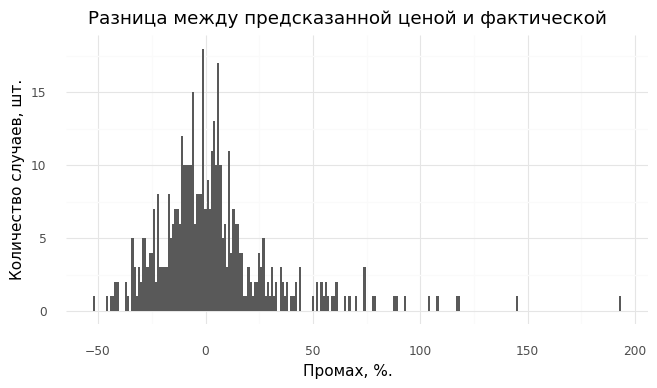

<ggplot: (8750464780463)>

In [100]:
diffs = (df_test['Цена']/df_test['Цена предсказанная'] - 1)
tbl = pd.DataFrame({'diffs': diffs * 100})

pred_diff_hist = (
    pn.ggplot(mapping=pn.aes(x='diffs'), data=tbl) +
    pn.geom_histogram(binwidth=1) +
    pn.theme_minimal() +
    pn.theme(figure_size=(7.5, 3.75)) +
    pn.xlab('Промах, %.') +
    pn.ylab('Количество случаев, шт.') +
    pn.ggtitle('Разница между предсказанной ценой и фактической')
)
pred_diff_hist

Положительные значения - случаи, когда фактическая цена выше предсказанной. Здесь видим, что много квартир, которым модель предсказала низкую цену, а по факту цена выше на 50 или больше процентов.

Отрицательные занчения, наоборот, говорят о том, что модель предсказала большую стоимость, чем было на самом деле. Видим, что тоже хватает случаев с серьезными промахами.

### Послесловие

Можно ли улучшить точность? Очень даже вероятно. Вот приемы которые бы нам помогли:

 - больше данных!
 - больше признаков в модель (у нас остались не использованными материал дома, тип ремонта);
 - добавить новых признаков. Например, использовать данные о прошлых продажаж, информацию о районе расположения квартиры, информацию об инфраструктуре (школ, торговых центров и т.д.)
 - пробовать другие типы моделей (градиентный бустинг, случайный лес)